In [21]:
from file_handle import load_file_standardize_header
import data_wrangle
import cluster
import ml_models
import optimize_for_mse_min
from utils import get_columns_by_mnemonics

## 1. Load file and merge header

In [22]:
file_path = r'c:/development/MSE_analysis/data/wanjing.csv'
df = load_file_standardize_header(file_path)
print("##### Final df after standardization #####")
print(df.head())
print(df.columns)

The first few rows of the original dataset are:
    Depth Interval Drilling_hour Drilling_time   ROP    WOB RPM_Total  \
        m        m             h           min   m/h     KN       rpm   
0  5311.2     0.20           0.1           6.2  1.96   9.93    45.323   
1  5311.4     0.41           0.2           5.6  1.99  14.77   273.065   
2  5311.6     0.60           0.3           5.8  1.99  12.46   273.065   
3  5311.8     0.80           0.4           4.5  2.12   9.90   273.065   
4  5312.0     1.00           0.4           4.0  2.26  13.81   270.065   

  TQ_Table         Si      Shale  Dolomite  Limestone  
      KN.m          %          %         %          %  
0     0.63  51.189020  18.351801  3.693265  24.529388  
1     6.02  51.189020  18.351801  3.693265  24.529388  
2     5.98  51.189020  18.351801  3.693265  24.529388  
3     6.02  51.189020  18.351801  3.693265  24.529388  
4     6.08  53.243932  17.737414  4.039584  22.811830  
##### Final df after standardization #####
   MD

## 2. Data Wrangle: 
Clean df from NAN or negative values in the targetted columns, remove outliers

In [23]:
mnemonics_to_clean = ['DOC', 'BIT_RPM', 'ROP', 'TORQUE', 'WOB', 'Si', 'Dolomite', 'Limestone', 'Shale', 'MSE']
df = data_wrangle.clean_df_by_mnemonics(df, mnemonics_to_clean)
df = data_wrangle.add_columns(df)
df.head()

c:\development\MSE_analysis\src\data_wrangle\clean_df.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[columns] = df[columns].applymap(lambda x: np.nan if x < 0 else x)


,MD (m),Interval__unidentified (m),Drilling_hour__unidentified (h),Drilling_time__unidentified (min),ROP (m/h),WOB (klbs),BIT_RPM (rpm),TORQUE (kLbf.ft),Si (%),Shale (%),Dolomite (%),Limestone (%),BIT_DIAMETER (in),DOC (in/rev),Mu,MSE (ksi)
0,5311.2,0.20,0.1,6.2,1.96,0.002234,45.323,0.464664,51.189020,18.351801,3.693265,24.529388,8.5,0.028376,880.827553,71.397531
1,5311.4,0.41,0.2,5.6,1.99,0.003323,273.065,4.440123,51.189020,18.351801,3.693265,24.529388,8.5,0.004782,5658.685877,4047.747585
2,5311.6,0.60,0.3,5.8,1.99,0.002804,273.065,4.410621,51.189020,18.351801,3.693265,24.529388,8.5,0.004782,6663.198202,4020.849391
3,5311.8,0.80,0.4,4.5,2.12,0.002227,273.065,4.440123,51.189020,18.351801,3.693265,24.529388,8.5,0.005094,8442.302061,3799.531520
4,5312.0,1.00,0.4,4.0,2.26,0.003107,270.065,4.484377,53.243932,17.737414,4.039584,22.811830,8.5,0.005491,6112.367965,3560.143820


In [24]:
# mnemonics_to_remove_outliers = ['DOC', 'TORQUE']
# df = data_wrangle.remove_outliers_by_mnemonics(
#     df, mnemonics_to_remove_outliers)

## 3. Clustering
- Sihouette scores of 3 or 4 clusters are very similar
- Cluster 2 does not have many data points (Check the result below)

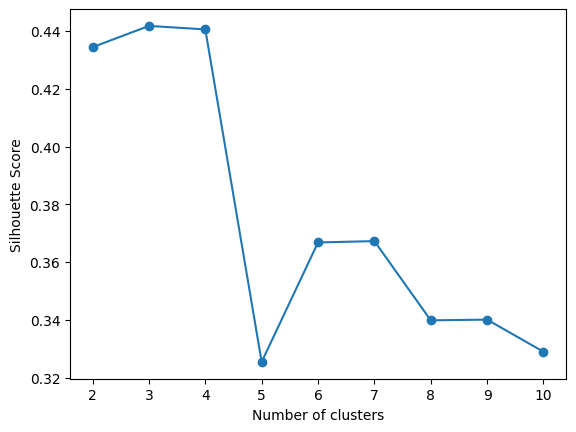

c:\Users\phamsonn\Anaconda3\envs\funix_DL\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [25]:
columns_for_clustering = ['DOC', 'TORQUE', 'WOB', 'Si', 'Dolomite', 'Limestone', 'Shale','MSE']
df = cluster.perform_kmeans(df, columns_for_clustering)

In [26]:
df['cluster'].value_counts()

cluster
1    565
0    274
2      9
Name: count, dtype: int64

In [27]:
# Statistical analysis of DOC and MSE of each cluster
df.groupby('cluster')[get_columns_by_mnemonics(df, 'DOC')].describe()

DOC (in/rev)                                                    \
               count      mean       std       min       25%       50%   
cluster                                                                  
0              274.0  0.006638  0.003121  0.005734  0.006177  0.006392   
1              565.0  0.005601  0.000236  0.005256  0.005434  0.005522   
2                9.0  0.007916  0.007682  0.004782  0.005094  0.005581   

                             
              75%       max  
cluster                      
0        0.006603  0.057488  
1        0.005755  0.006093  
2        0.005728  0.028376

In [28]:
df.groupby('cluster')[get_columns_by_mnemonics(df, 'MSE')].describe()

MSE (ksi)                                                      \
            count         mean          std          min          25%   
cluster                                                                 
0           274.0  3250.619940   414.572932    38.040043  3090.722317   
1           565.0  5065.446789   246.609434  3638.774655  4916.455034   
2             9.0  3295.051376  1227.274725    71.397531  3519.627584   

                                                
                 50%          75%          max  
cluster                                         
0        3305.224464  3437.943639  4548.999790  
1        5088.890823  5231.082727  5598.175036  
2        3560.143820  3799.531520  4047.747585

# 4. Model Training
- Scaler and best model for each cluster are achieved after this step

In [29]:
# CAUTION: cluster 2 only have 9 samples, which is too small to be used for training.
# We should remove cluster 2 from the training set. However, we still keep it, but needs to be
# aware of the small sample size issue impacting the training result of that cluster 2 significantly.
# As it is low ROP drilling, higher resolution of depth should be used to capture the trend. Or time-based
# analysis with reasonable resolution capturing drilling performance should be used.

X_mnemonics = ['TORQUE', 'WOB', 'RPM' , 'Mu', 'Si', 'Dolomite', 'Limestone', 'Shale']
y_mnemonic = 'ROP'

scalers_best_models = ml_models.perform_optimization(df, X_mnemonics, y_mnemonic)

##### X_mnemonics #####
['TORQUE', 'WOB', 'RPM', 'Mu', 'Si', 'Dolomite', 'Limestone', 'Shale']
##### X_cols #####
['TORQUE (kLbf.ft)', 'WOB (klbs)', 'BIT_RPM (rpm)', 'Mu', 'Si (%)', 'Dolomite (%)', 'Limestone (%)', 'Shale (%)']
Evaluating cluster 2
 ####### X shape is: 8 #########
 ####### X columns are: Index(['TORQUE (kLbf.ft)', 'WOB (klbs)', 'BIT_RPM (rpm)', 'Mu', 'Si (%)',
       'Dolomite (%)', 'Limestone (%)', 'Shale (%)'],
      dtype='object') #########
Cross-validation MSE scores for rf: [0.00278155 0.00121225 0.00609961 0.01547536 0.00154449 0.01600225
 0.00097969]
Average MSE for rf: 0.006299313571428565

Cross-validation MSE scores for xgb: [8.97786826e-04 1.85337556e-03 1.69374322e-02 2.54115602e-02
 7.25406580e-02 1.68841011e-02 9.76434063e-05]
Average MSE for xgb: 0.01923179390240121

Cross-validation MSE scores for svr: [0.01358548 0.00287023 0.01166206 0.04708573 0.0012958  0.00029883
 0.00011779]
Average MSE for svr: 0.010987988620346941

Cross-validation MSE scores f

## 5. Seeking Mechanical Specific Energy (MSE) min

In [30]:
clusters = optimize_for_mse_min.execute_monte_carlo_optimization(
    df_with_clusters=df, scalers_best_models=scalers_best_models, X_mnemonics=X_mnemonics, iterations=100)

df = optimize_for_mse_min.add_mse_min_to_original_data(df, clusters)

#### Seeking MSE min for cluster 2 #####


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:10<00:00,  1.90s/it]


Cluster: 2
Parameter Ranges for Low MSE:
TORQUE: 0.46 to 0.46
WOB: 0.00 to 0.00
RPM: 45.32 to 45.32
Mu: 23838.46 to 785570.23
Si: 52.56 to 53.24
Dolomite: 3.74 to 4.04
Limestone: 23.48 to 24.53
Shale: 18.00 to 18.35
Corresponding MSE Range: 18.32 to 18.32

#### Seeking MSE min for cluster 0 #####


100%|██████████| 100/100 [00:29<00:00,  3.38it/s]


Cluster: 0
Parameter Ranges for Low MSE:
TORQUE: 0.50 to 0.50
WOB: 0.00 to 0.00
RPM: 27.74 to 27.74
Mu: 9719.15 to 675588.48
Si: 61.56 to 75.32
Dolomite: 0.17 to 0.20
Limestone: 4.10 to 12.41
Shale: 16.78 to 31.10
Corresponding MSE Range: 11.91 to 11.91

#### Seeking MSE min for cluster 1 #####


100%|██████████| 100/100 [00:08<00:00, 11.49it/s]

Cluster: 1
Parameter Ranges for Low MSE:
TORQUE: 4.95 to 4.95
WOB: 0.00 to 0.00
RPM: 262.78 to 262.78
Mu: 13771.16 to 1025896.44
Si: 51.01 to 75.12
Dolomite: 0.03 to 0.47
Limestone: 2.91 to 19.35
Shale: 18.86 to 41.12
Corresponding MSE Range: 1129.44 to 1129.44



In [31]:
# Create output folder if not exists, then export df to csv
import os
output_folder = '../output'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
df.to_csv(os.path.join(output_folder, 'wanjing_with_mse_min.csv'), index=False)

In [32]:
# Summarize mse min for each cluster
df.groupby('cluster')['MSE_min (ksi)'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,274.0,11.912270,0.0,11.912270,11.912270,11.912270,11.912270,11.912270
1,565.0,1129.435495,0.0,1129.435495,1129.435495,1129.435495,1129.435495,1129.435495
2,9.0,18.322832,0.0,18.322832,18.322832,18.322832,18.322832,18.322832


In [33]:
df.columns

Index(['MD (m)', 'Interval__unidentified (m)',
       'Drilling_hour__unidentified (h)', 'Drilling_time__unidentified (min)',
       'ROP (m/h)', 'WOB (klbs)', 'BIT_RPM (rpm)', 'TORQUE (kLbf.ft)',
       'Si (%)', 'Shale (%)', 'Dolomite (%)', 'Limestone (%)',
       'BIT_DIAMETER (in)', 'DOC (in/rev)', 'Mu', 'MSE (ksi)', 'cluster',
       'MSE_min (ksi)'],
      dtype='object')

## 6. Suggest Drilling Parameters of The Drilled Interval

In [34]:
# from tqdm.notebook import tqdm
# import pandas as pd
# import numpy as np
# import math

# from config import config_constants

# from tqdm.notebook import tqdm


# # def sample_and_evaluate(df, X_mnemonics, scaler_best_models, mnemonic_constraints, mse_tolerance, num_samples=1000):
# #     X_mnemonics = [mnemonic.lower() for mnemonic in X_mnemonics]
# #     X_cols = get_columns_by_mnemonics(df, X_mnemonics)

# #     for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing rows"):
# #         cluster = row['cluster']
# #         mse_min = row['MSE_min (ksi)']
# #         mse_max = mse_min * (1 + mse_tolerance / 100)
# #         trained_model = scaler_best_models[cluster]['model']
# #         scaler = scaler_best_models[cluster]['scaler']

# #         sample_count = 0
# #         while sample_count < num_samples:
# #             sampled_params = {}
# #             for mnemonic in X_mnemonics:
# #                 if mnemonic in ['wob', 'rpm', 'torque']:
# #                     sampled_params[mnemonic] = np.random.uniform(*mnemonic_constraints.get(mnemonic, (0, 1)))
# #                 else:
# #                     sampled_params[mnemonic] = row[X_cols[X_mnemonics.index(mnemonic)]]

# #             # Calculate mu based on the formula
# #             sampled_params['mu'] = sampled_params['torque'] / (sampled_params['wob'] * config_constants['bit_diameter'] / 36)

# #             predicted_rop = trained_model.predict(scaler.fit_transform(np.array(list(sampled_params.values())).reshape(1, -1)))[0]

# #             wob_term = sampled_params['wob'] / \
# #                 ((config_constants["bit_diameter"]/2)**2 * math.pi)
# #             torque_term = 480 * sampled_params['torque'] * sampled_params['rpm'] / (
# #                 config_constants['bit_diameter']**2 * predicted_rop * 3.2808)
# #             predicted_mse = wob_term + torque_term

# #             if predicted_mse <= mse_max:
# #                 df.loc[_, 'suggested__WOB'] = sampled_params.get('wob')
# #                 df.loc[_, 'suggested__RPM'] = sampled_params.get('rpm')
# #                 df.loc[_, 'suggested__Torque'] = sampled_params.get('torque')
# #                 df.loc[_, 'suggested__Mu'] = sampled_params.get('mu')
# #                 df.loc[_, 'suggested__ROP'] = predicted_rop
# #                 sample_count += 1

# #     return df

# from scipy.optimize import minimize
# import numpy as np
# import pandas as pd

# # Hypothetical function to get columns based on mnemonics (as used in your original code)


# def get_columns_by_mnemonics(df, mnemonics):
#     # Implementation depends on how your DataFrame is structured
#     return [mnemonic for mnemonic in mnemonics if mnemonic in df.columns]

# # Define the objective function


# def objective_function(params, model, row, X_cols, X_mnemonics, config_constants):
#     # Extract parameters from the dictionary
#     wob = params['wob']
#     rpm = params['rpm']
#     torque = params['torque']
#     mu = torque / (wob * config_constants['bit_diameter'] / 36)

#     # Prepare the input for the model
#     X = row[X_cols].copy()
#     for i, mnemonic in enumerate(X_mnemonics):
#         if mnemonic in ['wob', 'rpm', 'torque']:
#             X[i] = params[mnemonic]

#     # Predict ROP
#     predicted_rop = model.predict([X])[0]

#     # Calculate MSE components
#     wob_term = wob / ((config_constants["bit_diameter"]/2)**2 * np.pi)
#     torque_term = 480 * torque * rpm / \
#         (config_constants['bit_diameter']**2 * predicted_rop * 3.2808)
#     predicted_mse = wob_term + torque_term

#     # Objective is to maximize ROP and minimize MSE
#     return -predicted_rop + predicted_mse

# # Function to perform optimization


# def optimize_parameters(row, model, X_cols, X_mnemonics, config_constants, bounds):
#     print("###### X_cols in optimize_parameters ######")
#     print(X_cols)
#     initial_guess = {
#         mnemonic: row[get_columns_by_mnemonics(X_cols, mnemonic)] for mnemonic in X_mnemonics}
#     result = minimize(objective_function, list(initial_guess.values()), args=(
#         model, row, X_cols, X_mnemonics, config_constants), bounds=bounds)
#     return result.x

# # Main function to apply optimization to each row
# def sample_and_optimize(df, X_mnemonics, scaler_best_models, mnemonic_constraints, config_constants):
#     print("###### df in sample_and_optimize ######")
#     print(df.head())
#     X_mnemonics = [mnemonic.lower() for mnemonic in X_mnemonics]
#     print("###### X_mnemonics in sample_and_optimize ######")
#     print(X_mnemonics)
#     X_cols = get_columns_by_mnemonics(df, X_mnemonics)
#     print("###### X_cols in sample_and_optimize ######")
#     print(X_cols)

#     for _, row in df.iterrows():
#         cluster = row['cluster']
#         trained_model = scaler_best_models[cluster]['model']
#         bounds = [mnemonic_constraints[mnemonic]
#                   for mnemonic in X_mnemonics if mnemonic in ['wob', 'rpm', 'torque']]

#         optimized_params = optimize_parameters(
#             row, trained_model, X_cols, X_mnemonics, config_constants, bounds)
#         df.loc[_, 'optimized_WOB'] = optimized_params[0]
#         df.loc[_, 'optimized_RPM'] = optimized_params[1]
#         df.loc[_, 'optimized_Torque'] = optimized_params[2]

#     return df


# mnemonic_constraints = {
#     'wob': (0.1, 40),  # Bounds for WOB in kLbs
#     'rpm': (150, 200),  # Bounds for RPM
#     'torque': (0.1, 10),  # Bounds for Torque in kFt-Lbs
#     'rop': (0.01, 1000),  # Bounds for ROP in m/h
# }

# print(scalers_best_models)
# # Example usage
# result_df = sample_and_optimize(
#     df, X_mnemonics, scalers_best_models, mnemonic_constraints, config_constants)
# print(result_df.head(10))


In [35]:
df.columns

Index(['MD (m)', 'Interval__unidentified (m)',
       'Drilling_hour__unidentified (h)', 'Drilling_time__unidentified (min)',
       'ROP (m/h)', 'WOB (klbs)', 'BIT_RPM (rpm)', 'TORQUE (kLbf.ft)',
       'Si (%)', 'Shale (%)', 'Dolomite (%)', 'Limestone (%)',
       'BIT_DIAMETER (in)', 'DOC (in/rev)', 'Mu', 'MSE (ksi)', 'cluster',
       'MSE_min (ksi)'],
      dtype='object')

In [41]:
import numpy as np
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from tqdm import tqdm
import math

from ml_models import perform_optimization
from config import config_constants
from utils import get_columns_by_mnemonics

def get_X_mnemonic_by_mnemonics(X_mnemonics, mnemonic):
    for X_mnemonic in X_mnemonics:
        if mnemonic.lower() in X_mnemonic.lower():
            return X_mnemonic
    return None

# Function to compute MSE
def compute_mse(wob, rpm, torque, rop):
    wob_term = wob / ((config_constants["bit_diameter"]/2)**2 * math.pi)
    torque_term = 480 * torque * rpm / \
        (config_constants['bit_diameter']**2 * rop * 3.2808)

    return wob_term + torque_term


def get_initial_guess_for_cluster(df, cluster, X_mnemonics):
    # Extract row for the cluster with all mnemonics
    row = df[df['cluster'] == cluster].iloc[0]
    initial_guess = [row[get_columns_by_mnemonics(df, mnemonic)[0]] for mnemonic in X_mnemonics]
    return np.array(initial_guess)


def optimize_for_cluster(df, scaler, trained_model, cluster, X_mnemonics, bounds, iterations):
    mse_min = df[df['cluster'] == cluster]['MSE_min (ksi)'].iloc[0]

    # def objective_function(params):
    #     wob, rpm, torque = params
    #     row = df[df['cluster'] == cluster].iloc[0]
    #     params_dict = {mnemonic: row[get_columns_by_mnemonics(df, mnemonic)[0]] for mnemonic in X_mnemonics if mnemonic not in ['wob', 'rpm', 'torque']}
    #     print("###### params_dict in objective_function before assigning wob, rpm, torque ######")
    #     print(params_dict)
    #     params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics,'wob')], params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics,'rpm')], params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics,'torque')] = wob, rpm, torque
    #     print("###### params_dict in objective_function after assigning wob, rpm, torque ######")
    #     print(params_dict)

    #     rop = trained_model.predict([list(params_dict.values())])[0]
    #     mse = compute_mse(wob, rpm, torque, rop)

    #     # Balancing ROP maximization and MSE minimization
    #     alpha = 0.5  # Adjust alpha to balance ROP and MSE
    #     composite_score = mse - alpha * rop / mse_min

    #     return composite_score

    def objective_function(params):
        wob, rpm, torque = params
        row = df[df['cluster'] == cluster].iloc[0]
        params_dict = {mnemonic: row[get_columns_by_mnemonics(df, mnemonic)[0]] for mnemonic in X_mnemonics if mnemonic not in ['wob', 'rpm', 'torque']}
        params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics,'wob')], params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics,'rpm')], params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics,'torque')] = wob, rpm, torque

        # Ensure the order of params_dict matches X_mnemonics
        params_list = [params_dict[mnemonic] for mnemonic in X_mnemonics]

        # Reshape params_list to a 2D array
        params_list = np.array(params_list).reshape(1, -1)

        rop = trained_model.predict(scaler.fit_transform(params_list))[0]
        mse = compute_mse(wob, rpm, torque, rop)

        # Balancing ROP maximization and MSE minimization
        alpha = 0.5  # Adjust alpha to balance ROP and MSE
        composite_score = mse - alpha * rop / mse_min

        return composite_score

    results = []
    for _ in tqdm(range(iterations)):
        initial_guess = get_initial_guess_for_cluster(df, cluster, X_mnemonics)
        bounds_sequence = [bounds[mnemonic]
                           for mnemonic in ['wob', 'rpm', 'torque']]
        result = minimize(
            objective_function, initial_guess[:3], method='L-BFGS-B', bounds=bounds_sequence)
        results.append((result.x, result.fun))

    best_result = min(results, key=lambda x: x[1])
    best_params, best_composite_score = best_result

    # Recalculate ROP and MSE for the best parameters
    wob, rpm, torque = best_params
    params_dict = {mnemonic: df[df['cluster'] ==
                                cluster].iloc[0][get_columns_by_mnemonics(df, mnemonic)[0]] for mnemonic in X_mnemonics}
    params_dict[get_X_mnemonic_by_mnemonics(
        X_mnemonics, 'wob')], params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics, 'rpm')], params_dict[get_X_mnemonic_by_mnemonics(X_mnemonics, 'torque')] = wob, rpm, torque
    best_rop = trained_model.predict([list(params_dict.values())])[0]
    best_mse = compute_mse(wob, rpm, torque, best_rop)

    return wob, rpm, torque, best_rop, best_mse


def get_bounds(df, column):
    return max(0.0001, df[column].min()), df[column].max()

def execute_monte_carlo_optimization(df_with_clusters, 
                                     scalers_best_models, 
                                     X_mnemonics, 
                                     bounds=None, 
                                     iterations=10, depth_or_cluster='cluster'):
    if bounds is None:
        # Calculate bounds once
        bounds = {
            'wob': get_bounds(df_with_clusters, get_columns_by_mnemonics(df_with_clusters, 'wob')[0]),
            'rpm': get_bounds(df_with_clusters, get_columns_by_mnemonics(df_with_clusters, 'rpm')[0]),
            'torque': get_bounds(df_with_clusters, get_columns_by_mnemonics(df_with_clusters, 'torque')[0])
        }
    if depth_or_cluster == 'depth':
        for index, row in df_with_clusters.iterrows():
            cluster = row['cluster']
            scaler = scalers_best_models[cluster]['scaler']
            trained_model = scalers_best_models[cluster]['model']

            wob, rpm, torque, best_rop, best_mse = optimize_for_cluster(
                df_with_clusters, scaler, trained_model, cluster, X_mnemonics, bounds, iterations)

            # Update the DataFrame with the optimized values
            df_with_clusters.loc[index, 'optimized_wob'] = wob
            df_with_clusters.loc[index, 'optimized_rpm'] = rpm
            df_with_clusters.loc[index, 'optimized_torque'] = torque
            df_with_clusters.loc[index, 'predicted_rop'] = best_rop
            df_with_clusters.loc[index, 'calculated_mse'] = best_mse

            # Print a progress message every 100 rows
            if index % 100 == 0:
                print(f"Completed optimization for {index} rows")

        return df_with_clusters

# def execute_monte_carlo_optimization(df_with_clusters, scalers_best_models, X_mnemonics, iterations):
#     for cluster in df_with_clusters['cluster'].unique():
#         print(f"#### Optimization for cluster {cluster} #####")
#         scaler = scalers_best_models[cluster]['scaler']
#         trained_model = scalers_best_models[cluster]['model']
#         bounds = {
#             'wob': get_bounds(df_with_clusters, get_columns_by_mnemonics(df_with_clusters, 'wob')[0]),
#             'rpm': get_bounds(df_with_clusters, get_columns_by_mnemonics(df_with_clusters, 'rpm')[0]),
#             'torque': get_bounds(df_with_clusters, get_columns_by_mnemonics(df_with_clusters, 'torque')[0])
#         }

#         wob, rpm, torque, best_rop, best_mse = optimize_for_cluster(
#             df_with_clusters, scaler, trained_model, cluster, X_mnemonics, bounds, iterations)

#         # Update the DataFrame with the optimized values
#         df_with_clusters.loc[df_with_clusters['cluster']
#                              == cluster, 'optimized_wob'] = wob
#         df_with_clusters.loc[df_with_clusters['cluster']
#                              == cluster, 'optimized_rpm'] = rpm
#         df_with_clusters.loc[df_with_clusters['cluster']
#                              == cluster, 'optimized_torque'] = torque
#         df_with_clusters.loc[df_with_clusters['cluster']
#                              == cluster, 'predicted_rop'] = best_rop
#         df_with_clusters.loc[df_with_clusters['cluster']
#                              == cluster, 'calculated_mse'] = best_mse

#     return df_with_clusters
bounds = {
    'wob': (1, 40), # in klbs
    'rpm': (140, 200), # in rpm
    'torque': (10, 15) # in klb.ft
}
final_df = execute_monte_carlo_optimization(df.head(5), scalers_best_models, X_mnemonics, iterations=5)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 10.99it/s]


Completed optimization for 0 rows


100%|██████████| 5/5 [00:00<00:00, 12.50it/s]


In [42]:
scalers_best_models

{2: {'scaler': StandardScaler(), 'model': RandomForestRegressor()},
 0: {'scaler': StandardScaler(),
  'model': <catboost.core.CatBoostRegressor at 0x233fe2376d0>},
 1: {'scaler': StandardScaler(),
  'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...)}}

In [39]:
final_df.head(10)

,MD (m),Interval__unidentified (m),Drilling_hour__unidentified (h),Drilling_time__unidentified (min),ROP (m/h),WOB (klbs),BIT_RPM (rpm),TORQUE (kLbf.ft),Si (%),Shale (%),...,DOC (in/rev),Mu,MSE (ksi),cluster,MSE_min (ksi),optimized_wob,optimized_rpm,optimized_torque,predicted_rop,calculated_mse
0,5311.2,0.20,0.1,6.2,1.96,0.002234,45.323,0.464664,51.189020,18.351801,...,0.028376,880.827553,71.397531,2,18.322832,0.001411,27.736,0.464664,2.327500,11.212897
1,5311.4,0.41,0.2,5.6,1.99,0.003323,273.065,4.440123,51.189020,18.351801,...,0.004782,5658.685877,4047.747585,2,18.322832,0.001411,27.736,0.464664,2.327500,11.212897
2,5311.6,0.60,0.3,5.8,1.99,0.002804,273.065,4.410621,51.189020,18.351801,...,0.004782,6663.198202,4020.849391,2,18.322832,0.001411,27.736,0.464664,2.327500,11.212897
3,5311.8,0.80,0.4,4.5,2.12,0.002227,273.065,4.440123,51.189020,18.351801,...,0.005094,8442.302061,3799.531520,2,18.322832,0.001411,27.736,0.464664,2.327500,11.212897
4,5312.0,1.00,0.4,4.0,2.26,0.003107,270.065,4.484377,53.243932,17.737414,...,0.005491,6112.367965,3560.143820,2,18.322832,0.001411,27.736,0.464664,2.327500,11.212897
5,5312.2,1.20,0.5,5.0,2.28,0.004408,268.065,4.565509,53.243932,17.737414,...,0.005581,4386.880490,3566.160796,2,18.322832,0.001411,27.736,0.464664,2.327500,11.212897
6,5312.4,1.40,0.6,5.2,2.29,0.004417,268.065,4.565509,53.243932,17.737414,...,0.005605,4377.941355,3550.588204,2,18.322832,0.001411,27.736,0.464664,2.327500,11.212897
7,5312.6,1.60,0.7,4.3,2.34,0.004223,268.065,4.624514,53.243932,17.737414,...,0.005728,4637.702206,3519.627584,2,18.322832,0.001411,27.736,0.464664,2.327500,11.212897
8,5312.8,1.80,0.8,4.6,2.37,0.004491,268.065,4.683519,53.243932,17.737414,...,0.005801,4416.851303,3519.415956,2,18.322832,0.001411,27.736,0.464664,2.327500,11.212897
9,5313.0,2.00,0.8,4.3,2.41,0.004298,268.065,4.690894,62.860313,30.848372,...,0.005899,4622.994094,3466.452087,0,11.912270,0.001411,27.736,0.464664,2.364534,11.037278


In [40]:
final_df.describe()

,MD (m),Interval__unidentified (m),Drilling_hour__unidentified (h),Drilling_time__unidentified (min),ROP (m/h),WOB (klbs),BIT_RPM (rpm),TORQUE (kLbf.ft),Si (%),Shale (%),...,DOC (in/rev),Mu,MSE (ksi),cluster,MSE_min (ksi),optimized_wob,optimized_rpm,optimized_torque,predicted_rop,calculated_mse
count,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,848.000000,...,848.000000,848.000000,848.000000,848.000000,848.000000,8.480000e+02,8.480000e+02,8.480000e+02,848.000000,848.000000
mean,5396.142453,85.142606,35.980307,5.206958,2.434717,0.011717,272.282112,5.915682,65.866472,27.810076,...,0.005961,2324.217900,4460.262691,0.687500,756.556512,1.410750e-03,2.773600e+01,4.646641e-01,2.342536,11.141393
std,49.153771,49.153811,21.485523,1.438872,0.144174,0.003438,15.627523,0.884043,4.612042,4.421936,...,0.002002,841.041678,917.716666,0.486157,527.175797,2.169684e-19,3.554810e-15,1.666317e-16,0.015215,0.072012
min,5311.200000,0.200000,0.100000,1.600000,1.960000,0.001411,27.736000,0.464664,51.007440,15.466302,...,0.004782,880.827553,38.040043,0.000000,11.912270,1.410750e-03,2.773600e+01,4.646641e-01,2.327500,11.037278
25%,5353.550000,42.550000,16.875000,4.300000,2.340000,0.009477,267.922000,4.897412,63.828609,24.608458,...,0.005477,1860.130017,3452.317038,0.000000,11.912270,1.410750e-03,2.773600e+01,4.646641e-01,2.332107,11.037278
50%,5396.300000,85.300000,36.350000,5.000000,2.350000,0.011743,268.780000,6.409414,65.858476,28.260670,...,0.005737,2108.633516,4915.806086,1.000000,1129.435495,1.410750e-03,2.773600e+01,4.646641e-01,2.332107,11.190746
75%,5438.650000,127.650000,54.525000,6.000000,2.500000,0.013876,280.363000,6.564302,68.907593,30.817254,...,0.006147,2520.782694,5154.758039,1.000000,1129.435495,1.410750e-03,2.773600e+01,4.646641e-01,2.364534,11.190746
max,5481.000000,170.000000,73.600000,15.000000,2.870000,0.020000,289.796000,6.800322,76.096554,41.121461,...,0.057488,10849.373245,5598.175036,2.000000,1129.435495,1.410750e-03,2.773600e+01,4.646641e-01,2.364534,11.212897
